In [1]:
import numpy as np
import pandas as pd 
import sklearn
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Reading data from input file
df = pd.read_csv("Appointment-No-Show-Data.csv")
print(df.dtypes)
print("------------------------------------------")
df.shape

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object
------------------------------------------


(110527, 14)

In [3]:
# Renaming No-Show column entity

df = df.rename(columns={"No-show": "no_show"})
df.no_show = df.no_show.map({ 'No': 0, 'Yes': 1 })
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"])
df["WeekdayScheduled"] = df["ScheduledDay"].dt.weekday
df['awaiting_time_days'] = (df.AppointmentDay - df.ScheduledDay).dt.days
df = df[(df.awaiting_time_days >= 0)]

In [4]:
df = df[df["Age"] <100]
df = df[df["Age"] > -1] 

# Question 1
no_show = len(df.query('no_show == "1"'))
no_show_ratio = int(round(no_show/len(df)*100))

print("Total proportion of patients with no show:",no_show_ratio)


Total proportion of patients with no show: 20


In [5]:
# Performing dummies operation
df[['Handcap']] = df[['Handcap']].astype('str')
df_cat = pd.get_dummies(df[['Gender'] + ['Handcap']],drop_first = True)
cols_all_cat = list(df_cat.columns)
print(df_cat.head())
df = pd.concat([df,df_cat], axis = 1)

cols_input = ['Scholarship','Hipertension', 'Diabetes', 'Alcoholism',
       'SMS_received', 'Age', 'awaiting_time_days', 'WeekdayScheduled','no_show']

   Gender_M  Handcap_1  Handcap_2  Handcap_3  Handcap_4
0         0          0          0          0          0
1         1          0          0          0          0
2         0          0          0          0          0
3         0          0          0          0          0
4         0          0          0          0          0


In [6]:
df_final = df[cols_input+cols_all_cat]

In [7]:
# Train and test data 

df_final = df_final.sample(n = len(df_final), random_state = 20)
df_final = df_final.reset_index(drop = True)

df_test=df_final.sample(frac=0.20,random_state=20)
df_train = df_final.drop(df_test.index)

In [8]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Train prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.no_show.values)))
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.no_show.values)))

Train prevalence(n = 88408):0.201
Test prevalence(n = 22102):0.205


In [9]:
# Balancing the data

rows_pos = df_train.no_show == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

n = np.min([len(df_train_pos), len(df_train_neg)])

# merge the balanced data
df_train = pd.concat([df_train_pos.sample(n = n, random_state = 20), 
                      df_train_neg.sample(n = n, random_state = 20)],axis = 0, 
                     ignore_index = True)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 20).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.no_show.values)))

Train balanced prevalence(n = 35566):0.500


In [10]:
# 
cols_input = ['Scholarship','Hipertension', 'Diabetes', 'Alcoholism',
       'SMS_received', 'Age', 'awaiting_time_days', 'WeekdayScheduled'] + cols_all_cat


X_train = df_train[cols_input].values
y_train = df_train['no_show'].values

X_test = df_test[cols_input].values
y_test = df_test['no_show'].values

print('Training shapes:',X_train.shape, y_train.shape)
print('Testing shapes:',X_test.shape, y_test.shape)


Training shapes: (35566, 13) (35566,)
Testing shapes: (22102, 13) (22102,)


In [11]:
# Metrics selection
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1score = f1_score(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print('F1_score:%.3f'%f1score)
    print(' ')
    return auc, accuracy, recall, precision, specificity 


In [12]:
# Logistic Regression
lr = LogisticRegression(random_state = 20)
y_train_preds = cross_val_predict(lr, X_train, y_train, cv=5)

print(y_train_preds)

print('Logistic Regression - 5 folds')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, .5)


[1 0 0 ... 1 0 0]
Logistic Regression - 5 folds
Training:
AUC:0.628
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
F1_score:0.600
 


In [13]:
# Comments - The Logistic regression model with 5-folds CV is better than the naive model which predicts outcome 
# as show up because we have a model accuracy of 62% which is greater than 50%(Tossing a coin).


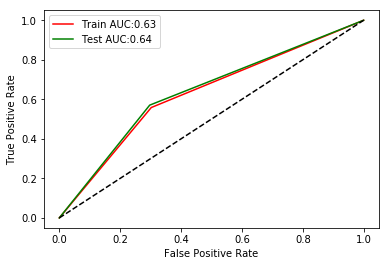

In [13]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# lr=LogisticRegression(random_state = 20)
a = lr.fit(X_train, y_train)
y_test_preds = lr.predict(X_test)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.2f'%auc_train)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.2f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
# The results obtained show a marginal AUC curve with 63% accuracy. Hence the model is not that great. 
# Still the model can be improved is we have additional data.

In [ ]:
# Details needed for better prediction
# Schedule of patients on date of arrival. We need to have patients schedule in advance to make prediction of no-show
# Receiving the message - Patients should acknowledge the message received by them. 
# Demographical and Climatic conditions on a given day 
# We could do the same analysis with over sampling to see the performance improvement